In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter

# === Step 1: Load and preprocess data ===
df = pd.read_csv("MAINDiagnostics.csv")
df = df.drop(columns=["IDFILENAME", "FileName", "Beat"])
df["Gender"] = df["Gender"].map({"MALE": 1, "FEMALE": 0})

normal_group = ["SR", "SB", "ST", "SI", "SAAWR"]
arrhythmia_group = ["AFIB", "AF", "SVT", "AT", "AVNRT", "AVRT"]
df["Rhythm_Binary"] = df["Rhythm"].apply(lambda x: 0 if x in normal_group else (1 if x in arrhythmia_group else np.nan))
df = df.dropna(subset=["Rhythm_Binary"])

X = df.drop(columns=["Rhythm", "Rhythm_Binary"], errors='ignore').values
y = df["Rhythm_Binary"].astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === SSO-inspired oversampling for class 1 ===
X_min = X_scaled[y == 1]
X_maj = X_scaled[y == 0]
n_to_generate = len(X_maj) - len(X_min)

def sso_augment(X, n_samples):
    n_features = X.shape[1]
    augmented = []
    for _ in range(n_samples):
        i, j = np.random.choice(len(X), 2, replace=False)
        alpha = np.random.uniform(-1, 1, n_features)
        sample = X[i] + alpha * (X[j] - X[i])
        augmented.append(sample)
    return np.array(augmented)

X_syn = sso_augment(X_min, n_to_generate)
y_syn = np.ones(n_to_generate, dtype=int)

X_bal = np.vstack([X_scaled, X_syn])
y_bal = np.concatenate([y, y_syn])

# === Train/test split ===
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal)
input_dim = X_train.shape[1]

# === Step 2: Define fuzzy membership layer ===
class FuzzyLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, num_memberships):
        super(FuzzyLayer, self).__init__()
        self.in_features = in_features
        self.num_memberships = num_memberships
        self.mu = self.add_weight("mu", shape=[num_memberships, in_features], initializer="random_normal", trainable=True)
        self.sigma = self.add_weight("sigma", shape=[num_memberships, in_features], initializer="ones", trainable=True)

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        mu = tf.expand_dims(self.mu, axis=0)
        sigma = tf.expand_dims(self.sigma, axis=0)
        return tf.exp(-tf.square((x - mu) / sigma))

# === Step 3: Build model ===
def build_model(mu_init, sigma_init):
    fuzzy = FuzzyLayer(input_dim, num_memberships=3)
    fuzzy.mu.assign(tf.convert_to_tensor(mu_init, dtype=tf.float32))
    fuzzy.sigma.assign(tf.convert_to_tensor(sigma_init, dtype=tf.float32))
    
    inputs = tf.keras.Input(shape=(input_dim,))
    fuzzy_out = fuzzy(inputs)
    flat = tf.keras.layers.Flatten()(fuzzy_out)
    dense1 = tf.keras.layers.Dense(128, activation='relu')(flat)
    drop = tf.keras.layers.Dropout(0.2)(dense1)
    dense2 = tf.keras.layers.Dense(64, activation='relu')(drop)
    output = tf.keras.layers.Dense(2, activation='softmax')(dense2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Step 4: WHHO optimization ===
def fitness_function(position):
    mu = position[:len(position)//2].reshape(3, input_dim)
    sigma = np.abs(position[len(position)//2:].reshape(3, input_dim)) + 1e-2
    model = build_model(mu, sigma)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = np.argmax(model.predict(X_val), axis=1)
    return 1 - accuracy_score(y_val, y_pred)

def whho_optimize(dim, n_agents=5, max_iter=5):
    pop = np.random.uniform(-1, 1, (n_agents, dim))
    fitness = np.array([fitness_function(ind) for ind in pop])
    best_idx = np.argmin(fitness)
    best = pop[best_idx]

    for _ in range(max_iter):
        for i in range(n_agents):
            r = np.random.rand()
            pop[i] = pop[i] + r * (best - pop[i])
            fitness[i] = fitness_function(pop[i])
        best_idx = np.argmin(fitness)
        best = pop[best_idx]
    return best

dim = 2 * 3 * input_dim
opt_vector = whho_optimize(dim)
mu_opt = opt_vector[:len(opt_vector)//2].reshape(3, input_dim)
sigma_opt = np.abs(opt_vector[len(opt_vector)//2:].reshape(3, input_dim)) + 1e-2

# === Step 5: Train final model ===
final_model = build_model(mu_opt, sigma_opt)
final_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1)

# === Step 6: Evaluate ===
y_pred_final = np.argmax(final_model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred_final, target_names=["Normal", "Arrhythmia"]))


92/92 [==============================] - 0s 621us/step
Epoch 1/30
365/365 [==============================] - 1s 1ms/step - loss: 0.4061 - accuracy: 0.8109 - val_loss: 0.2939 - val_accuracy: 0.8762
Epoch 2/30
365/365 [==============================] - 0s 1ms/step - loss: 0.2812 - accuracy: 0.8888 - val_loss: 0.2276 - val_accuracy: 0.9112
Epoch 3/30
365/365 [==============================] - 0s 999us/step - loss: 0.2362 - accuracy: 0.9079 - val_loss: 0.1894 - val_accuracy: 0.9321
Epoch 4/30
365/365 [==============================] - 0s 982us/step - loss: 0.1969 - accuracy: 0.9291 - val_loss: 0.1913 - val_accuracy: 0.9290
Epoch 5/30
365/365 [==============================] - 0s 963us/step - loss: 0.1754 - accuracy: 0.9346 - val_loss: 0.1599 - val_accuracy: 0.9431
Epoch 6/30
365/365 [==============================] - 0s 979us/step - loss: 0.1597 - accuracy: 0.9435 - val_loss: 0.1519 - val_accuracy: 0.9472
Epoch 7/30
365/365 [==============================] - 0s 973us/step - loss: 0.1478 - 

4/4 [==============================] - 0s 665us/step


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

313/313 [==============================] - 0s 562us/step


  1%|▊                                                                                 | 1/100 [00:00<00:28,  3.44it/s]

313/313 [==============================] - 0s 546us/step


  2%|█▋                                                                                | 2/100 [00:00<00:28,  3.48it/s]

313/313 [==============================] - 0s 636us/step


  3%|██▍                                                                               | 3/100 [00:00<00:29,  3.33it/s]

313/313 [==============================] - 0s 553us/step


  4%|███▎                                                                              | 4/100 [00:01<00:28,  3.37it/s]

313/313 [==============================] - 0s 546us/step


  5%|████                                                                              | 5/100 [00:01<00:27,  3.42it/s]

313/313 [==============================] - 0s 521us/step


  6%|████▉                                                                             | 6/100 [00:01<00:27,  3.48it/s]

313/313 [==============================] - 0s 591us/step


  7%|█████▋                                                                            | 7/100 [00:02<00:27,  3.42it/s]

313/313 [==============================] - 0s 552us/step


  8%|██████▌                                                                           | 8/100 [00:02<00:26,  3.45it/s]

313/313 [==============================] - 0s 543us/step


  9%|███████▍                                                                          | 9/100 [00:02<00:26,  3.46it/s]

313/313 [==============================] - 0s 537us/step


 10%|████████                                                                         | 10/100 [00:02<00:25,  3.47it/s]

313/313 [==============================] - 0s 533us/step


 11%|████████▉                                                                        | 11/100 [00:03<00:25,  3.51it/s]

313/313 [==============================] - 0s 559us/step


 12%|█████████▋                                                                       | 12/100 [00:03<00:25,  3.49it/s]

313/313 [==============================] - 0s 527us/step


 13%|██████████▌                                                                      | 13/100 [00:03<00:24,  3.50it/s]

313/313 [==============================] - 0s 553us/step


 14%|███████████▎                                                                     | 14/100 [00:04<00:24,  3.48it/s]

313/313 [==============================] - 0s 559us/step


 15%|████████████▏                                                                    | 15/100 [00:04<00:24,  3.48it/s]

313/313 [==============================] - 0s 533us/step


 16%|████████████▉                                                                    | 16/100 [00:04<00:24,  3.49it/s]

313/313 [==============================] - 0s 524us/step


 17%|█████████████▊                                                                   | 17/100 [00:04<00:24,  3.44it/s]

313/313 [==============================] - 0s 566us/step


 18%|██████████████▌                                                                  | 18/100 [00:05<00:23,  3.44it/s]

313/313 [==============================] - 0s 525us/step


 19%|███████████████▍                                                                 | 19/100 [00:05<00:23,  3.47it/s]

313/313 [==============================] - 0s 529us/step


 20%|████████████████▏                                                                | 20/100 [00:05<00:22,  3.51it/s]

313/313 [==============================] - 0s 570us/step


 21%|█████████████████                                                                | 21/100 [00:06<00:22,  3.46it/s]

313/313 [==============================] - 0s 559us/step


 22%|█████████████████▊                                                               | 22/100 [00:06<00:22,  3.46it/s]

313/313 [==============================] - 0s 521us/step


 23%|██████████████████▋                                                              | 23/100 [00:06<00:22,  3.50it/s]

313/313 [==============================] - 0s 529us/step


 24%|███████████████████▍                                                             | 24/100 [00:06<00:21,  3.53it/s]

313/313 [==============================] - 0s 589us/step


 25%|████████████████████▎                                                            | 25/100 [00:07<00:21,  3.47it/s]

313/313 [==============================] - 0s 520us/step


 26%|█████████████████████                                                            | 26/100 [00:07<00:21,  3.49it/s]

313/313 [==============================] - 0s 517us/step


 27%|█████████████████████▊                                                           | 27/100 [00:07<00:20,  3.54it/s]

313/313 [==============================] - 0s 530us/step


 28%|██████████████████████▋                                                          | 28/100 [00:08<00:20,  3.56it/s]

313/313 [==============================] - 0s 562us/step


 29%|███████████████████████▍                                                         | 29/100 [00:08<00:20,  3.50it/s]

313/313 [==============================] - 0s 559us/step


 30%|████████████████████████▎                                                        | 30/100 [00:08<00:20,  3.48it/s]

313/313 [==============================] - 0s 517us/step


 31%|█████████████████████████                                                        | 31/100 [00:08<00:19,  3.52it/s]

313/313 [==============================] - 0s 524us/step


 32%|█████████████████████████▉                                                       | 32/100 [00:09<00:19,  3.56it/s]

313/313 [==============================] - 0s 527us/step


 33%|██████████████████████████▋                                                      | 33/100 [00:09<00:18,  3.59it/s]

313/313 [==============================] - 0s 578us/step


 34%|███████████████████████████▌                                                     | 34/100 [00:09<00:18,  3.53it/s]

313/313 [==============================] - 0s 553us/step


 35%|████████████████████████████▎                                                    | 35/100 [00:10<00:18,  3.52it/s]

313/313 [==============================] - 0s 514us/step


 36%|█████████████████████████████▏                                                   | 36/100 [00:10<00:17,  3.56it/s]

313/313 [==============================] - 0s 549us/step


 37%|█████████████████████████████▉                                                   | 37/100 [00:10<00:17,  3.55it/s]

313/313 [==============================] - 0s 535us/step


 38%|██████████████████████████████▊                                                  | 38/100 [00:10<00:17,  3.55it/s]

313/313 [==============================] - 0s 533us/step


 39%|███████████████████████████████▌                                                 | 39/100 [00:11<00:17,  3.55it/s]

313/313 [==============================] - 0s 532us/step


 40%|████████████████████████████████▍                                                | 40/100 [00:11<00:16,  3.56it/s]

313/313 [==============================] - 0s 520us/step


 41%|█████████████████████████████████▏                                               | 41/100 [00:11<00:16,  3.60it/s]

313/313 [==============================] - 0s 539us/step


 42%|██████████████████████████████████                                               | 42/100 [00:11<00:16,  3.59it/s]

313/313 [==============================] - 0s 541us/step


 43%|██████████████████████████████████▊                                              | 43/100 [00:12<00:15,  3.58it/s]

313/313 [==============================] - 0s 541us/step


 44%|███████████████████████████████████▋                                             | 44/100 [00:12<00:15,  3.58it/s]

313/313 [==============================] - 0s 577us/step


 45%|████████████████████████████████████▍                                            | 45/100 [00:12<00:15,  3.52it/s]

313/313 [==============================] - 0s 562us/step


 46%|█████████████████████████████████████▎                                           | 46/100 [00:13<00:15,  3.50it/s]

313/313 [==============================] - 0s 576us/step


 47%|██████████████████████████████████████                                           | 47/100 [00:13<00:15,  3.46it/s]

313/313 [==============================] - 0s 613us/step


 48%|██████████████████████████████████████▉                                          | 48/100 [00:13<00:15,  3.41it/s]

313/313 [==============================] - 0s 546us/step


 49%|███████████████████████████████████████▋                                         | 49/100 [00:14<00:14,  3.45it/s]

313/313 [==============================] - 0s 530us/step


 50%|████████████████████████████████████████▌                                        | 50/100 [00:14<00:14,  3.50it/s]

313/313 [==============================] - 0s 543us/step


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:14<00:13,  3.52it/s]

313/313 [==============================] - 0s 521us/step


 52%|██████████████████████████████████████████                                       | 52/100 [00:14<00:13,  3.56it/s]

313/313 [==============================] - 0s 533us/step


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:15<00:13,  3.58it/s]

313/313 [==============================] - 0s 511us/step


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:15<00:12,  3.61it/s]

313/313 [==============================] - 0s 569us/step


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:15<00:12,  3.55it/s]

313/313 [==============================] - 0s 551us/step


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:15<00:12,  3.51it/s]

313/313 [==============================] - 0s 553us/step


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:16<00:12,  3.48it/s]

313/313 [==============================] - 0s 561us/step


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:16<00:12,  3.45it/s]

313/313 [==============================] - 0s 553us/step


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:16<00:11,  3.45it/s]

313/313 [==============================] - 0s 604us/step


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:17<00:11,  3.41it/s]

313/313 [==============================] - 0s 574us/step


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:17<00:11,  3.43it/s]

313/313 [==============================] - 0s 647us/step


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:17<00:11,  3.33it/s]

313/313 [==============================] - 0s 586us/step


 63%|███████████████████████████████████████████████████                              | 63/100 [00:18<00:11,  3.32it/s]

313/313 [==============================] - 0s 578us/step


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:18<00:10,  3.34it/s]

313/313 [==============================] - 0s 550us/step


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:18<00:10,  3.38it/s]

313/313 [==============================] - 0s 610us/step


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:18<00:10,  3.35it/s]

313/313 [==============================] - 0s 546us/step


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:19<00:09,  3.38it/s]

313/313 [==============================] - 0s 560us/step


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:19<00:09,  3.39it/s]

313/313 [==============================] - 0s 524us/step


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:19<00:08,  3.46it/s]

313/313 [==============================] - 0s 533us/step


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:20<00:08,  3.49it/s]

313/313 [==============================] - 0s 583us/step


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:20<00:08,  3.45it/s]

313/313 [==============================] - 0s 569us/step


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:20<00:08,  3.45it/s]

313/313 [==============================] - 0s 559us/step


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:20<00:07,  3.47it/s]

313/313 [==============================] - 0s 521us/step


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:21<00:07,  3.50it/s]

313/313 [==============================] - 0s 524us/step


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:21<00:07,  3.55it/s]

313/313 [==============================] - 0s 594us/step


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:21<00:06,  3.48it/s]

313/313 [==============================] - 0s 559us/step


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:22<00:06,  3.47it/s]

313/313 [==============================] - 0s 521us/step


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:22<00:06,  3.51it/s]

313/313 [==============================] - 0s 559us/step


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:22<00:06,  3.49it/s]

313/313 [==============================] - 0s 549us/step


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:22<00:05,  3.50it/s]

313/313 [==============================] - 0s 553us/step


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:23<00:05,  3.49it/s]

313/313 [==============================] - 0s 588us/step


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:23<00:05,  3.43it/s]

313/313 [==============================] - 0s 536us/step


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:23<00:04,  3.47it/s]

313/313 [==============================] - 0s 524us/step


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:24<00:04,  3.51it/s]

313/313 [==============================] - 0s 537us/step


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:24<00:04,  3.53it/s]

313/313 [==============================] - 0s 559us/step


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:24<00:03,  3.51it/s]

313/313 [==============================] - 0s 524us/step


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:24<00:03,  3.55it/s]

313/313 [==============================] - 0s 524us/step


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:25<00:03,  3.60it/s]

313/313 [==============================] - 0s 518us/step


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:25<00:03,  3.63it/s]

313/313 [==============================] - 0s 527us/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:25<00:02,  3.63it/s]

313/313 [==============================] - 0s 533us/step


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:26<00:02,  3.64it/s]

313/313 [==============================] - 0s 519us/step


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:26<00:02,  3.65it/s]

313/313 [==============================] - 0s 517us/step


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:26<00:01,  3.67it/s]

313/313 [==============================] - 0s 511us/step


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:26<00:01,  3.66it/s]

313/313 [==============================] - 0s 559us/step


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:27<00:01,  3.61it/s]

313/313 [==============================] - 0s 533us/step


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:27<00:01,  3.60it/s]

313/313 [==============================] - 0s 540us/step


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:27<00:00,  3.58it/s]

313/313 [==============================] - 0s 556us/step


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:27<00:00,  3.54it/s]

313/313 [==============================] - 0s 549us/step


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:28<00:00,  3.53it/s]

313/313 [==============================] - 0s 521us/step


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.50it/s]
C:\Users\Arman\AppData\Local\Temp\ipykernel_1560\190547129.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_sample, feature_names=feature_names, show=False)


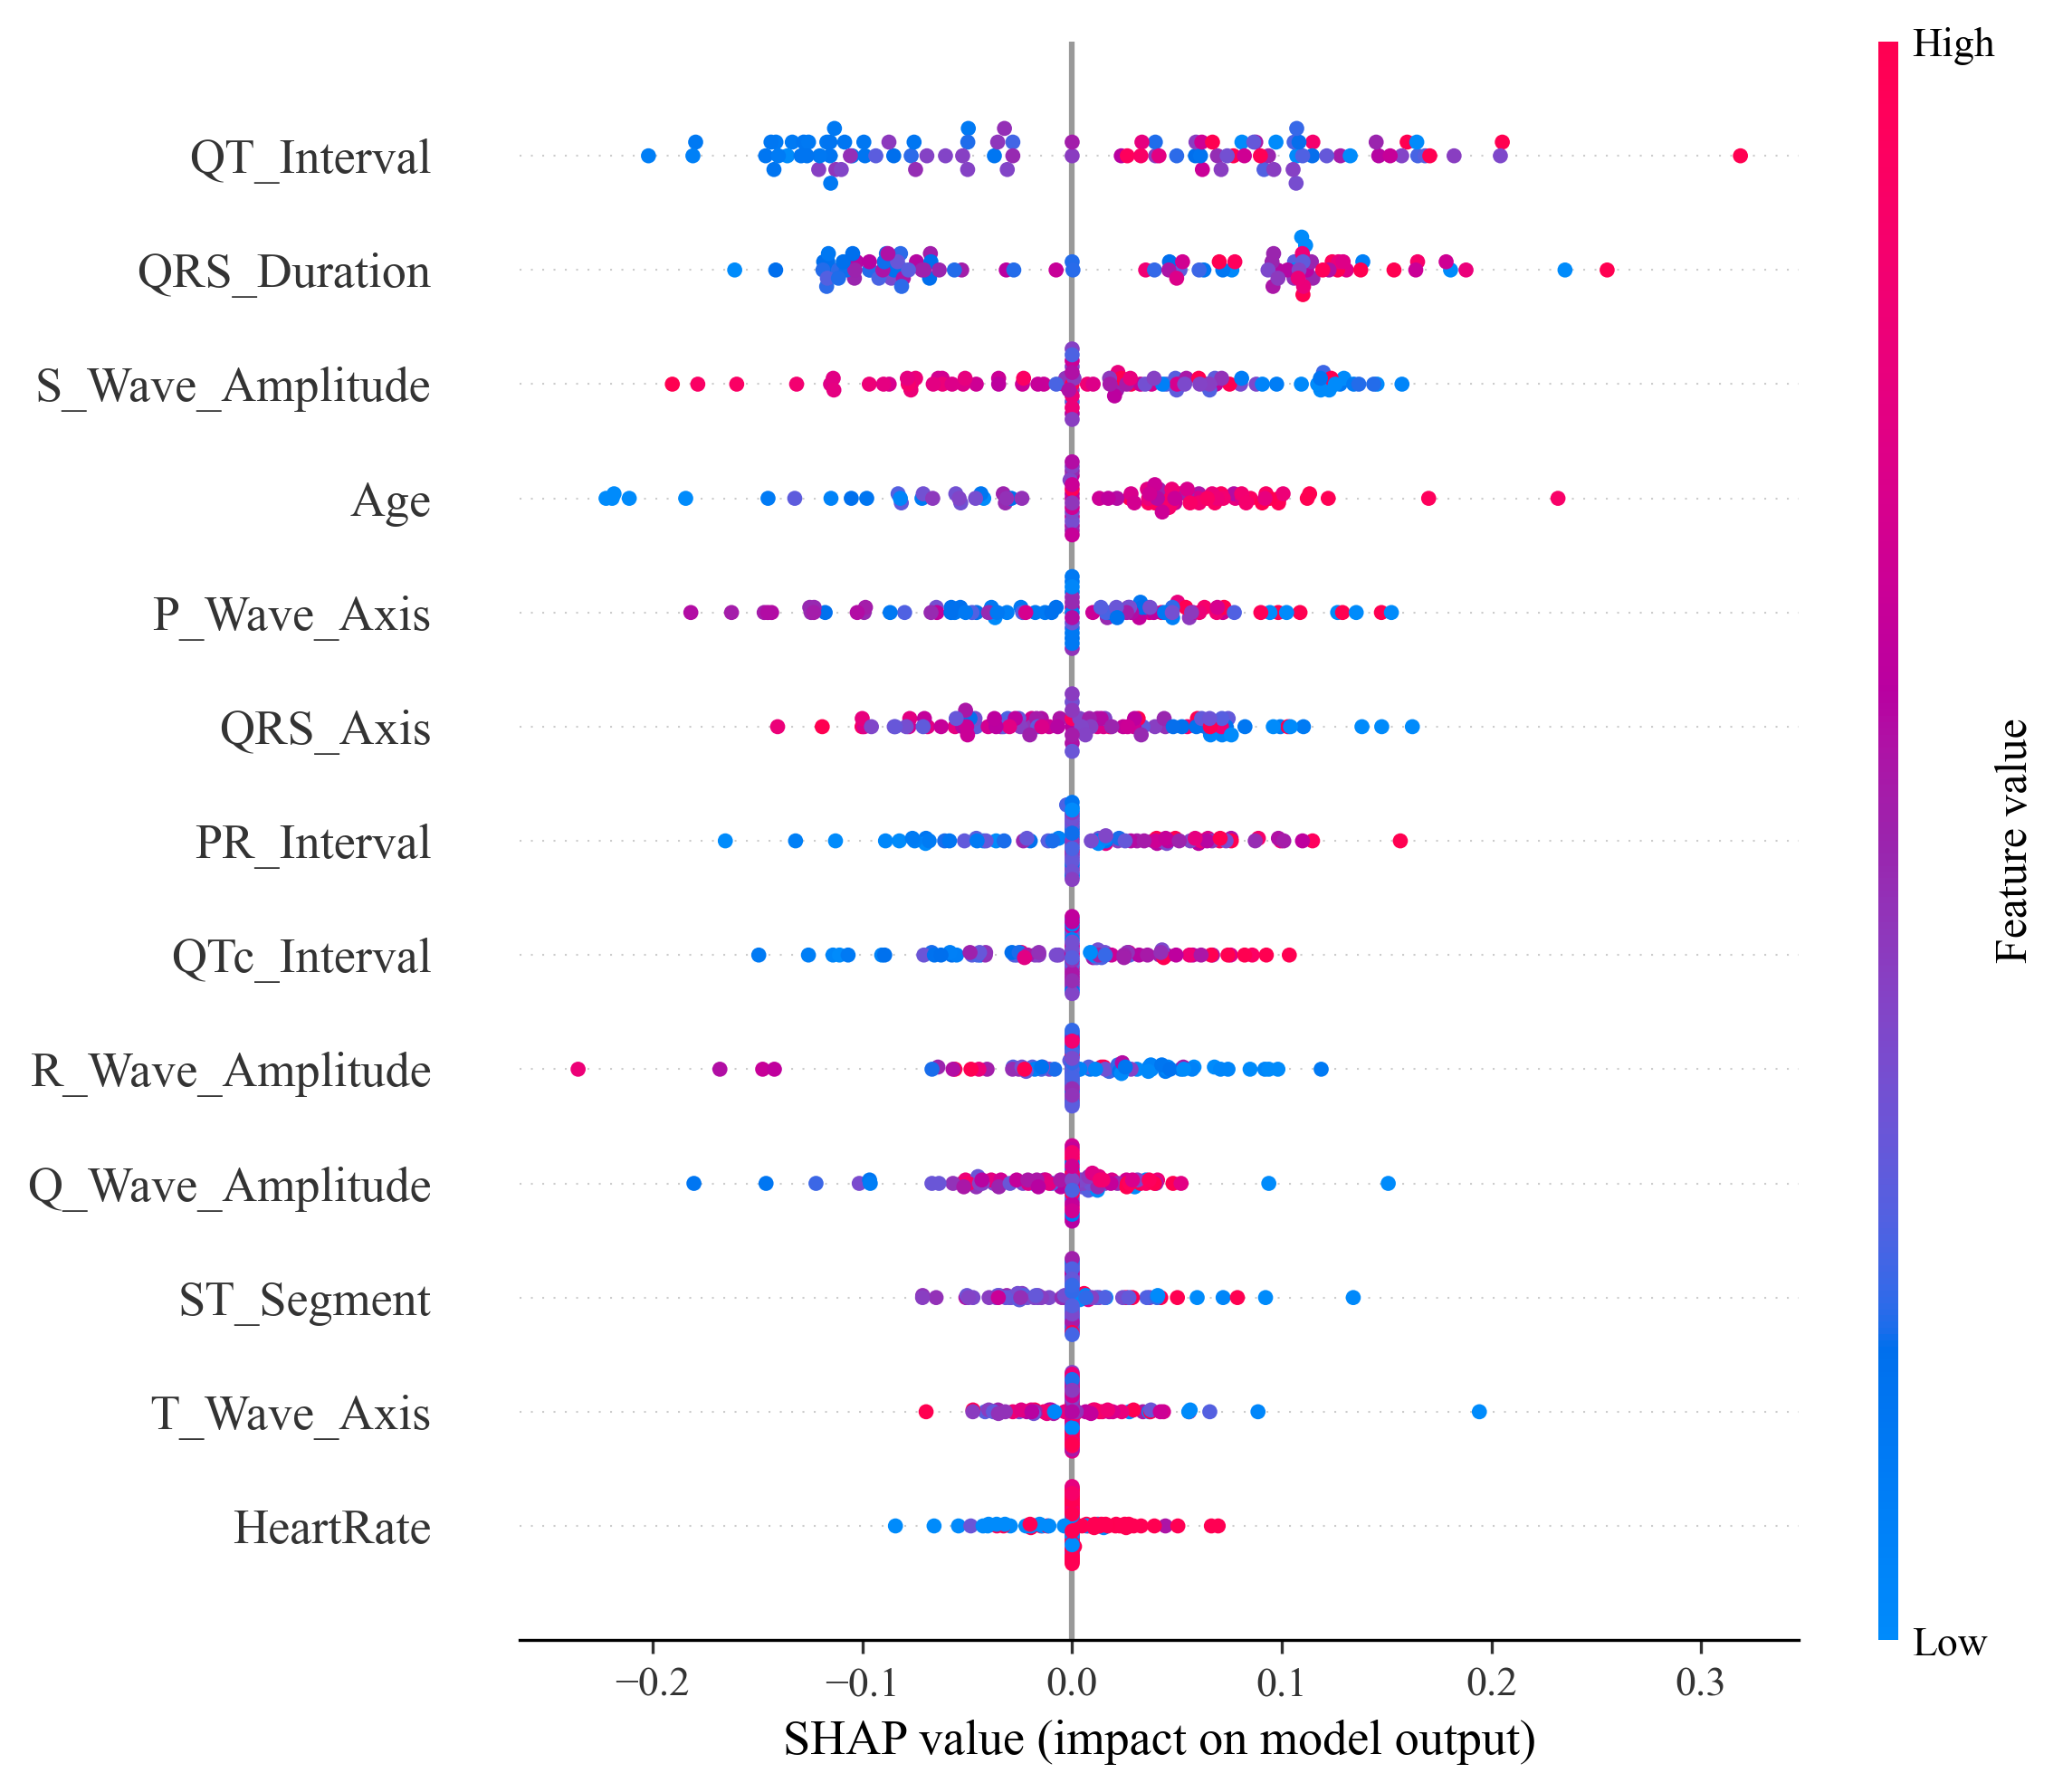

In [12]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set font to Times New Roman for all plots
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Define a wrapper that returns only the probability of class 1 (Arrhythmia)
def predict_class1(X):
    preds = model.predict(X)
    return preds[:, 1]  # Return only class 1 probability

# Select 100 samples from training data as background
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Select 100 validation samples to explain
X_val_sample = X_val[:100]

# Create SHAP KernelExplainer using the wrapped prediction function
explainer = shap.KernelExplainer(predict_class1, background)

# Compute SHAP values for the validation sample
shap_values = explainer.shap_values(X_val_sample, nsamples=100)

# Plot summary plot (high resolution, Times New Roman font)
plt.figure(figsize=(10, 6), dpi=300)  # High DPI for better quality
shap.summary_plot(shap_values, X_val_sample, feature_names=feature_names, show=False)
plt.tight_layout()
plt.savefig("shap_summary_arrhythmia_highres.png", dpi=300)
plt.show()


157/157 [==============================] - 0s 545us/step


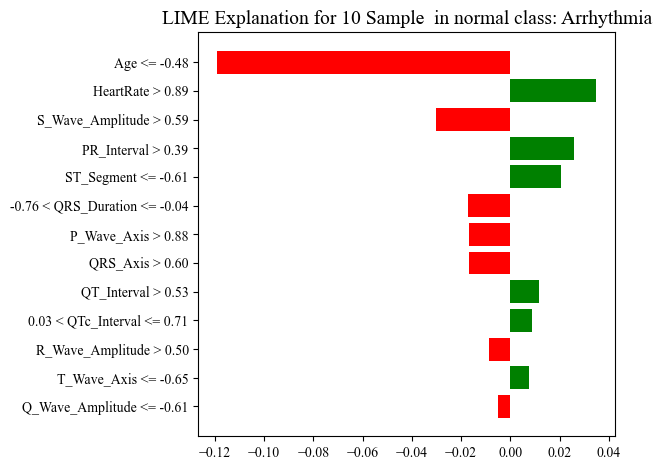

In [13]:
from lime import lime_tabular
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set global font to Times New Roman
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Define class names
class_names = ["Normal", "Arrhythmia"]

# Create LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification',
    discretize_continuous=True
)

# Define model prediction wrapper
def predict_fn(x):
    return model.predict(x)

# Select a validation instance to explain
i = 10
exp = lime_explainer.explain_instance(
    X_val[i],
    predict_fn,
    num_features=13,
    top_labels=1
)

# Correct usage: call the method to get available labels
available = exp.available_labels()

# Use the first available label (e.g., predicted class)
label_to_use = available[0]

# Plot explanation
fig = exp.as_pyplot_figure(label=label_to_use)
plt.title(f"LIME Explanation for {i} Sample  in normal class: {class_names[label_to_use]}", fontname="Times New Roman", fontsize=14)
plt.tight_layout()
plt.savefig("lime_explanation_sample10.png", dpi=300)
plt.show()


92/92 [==============================] - 0s 515us/step


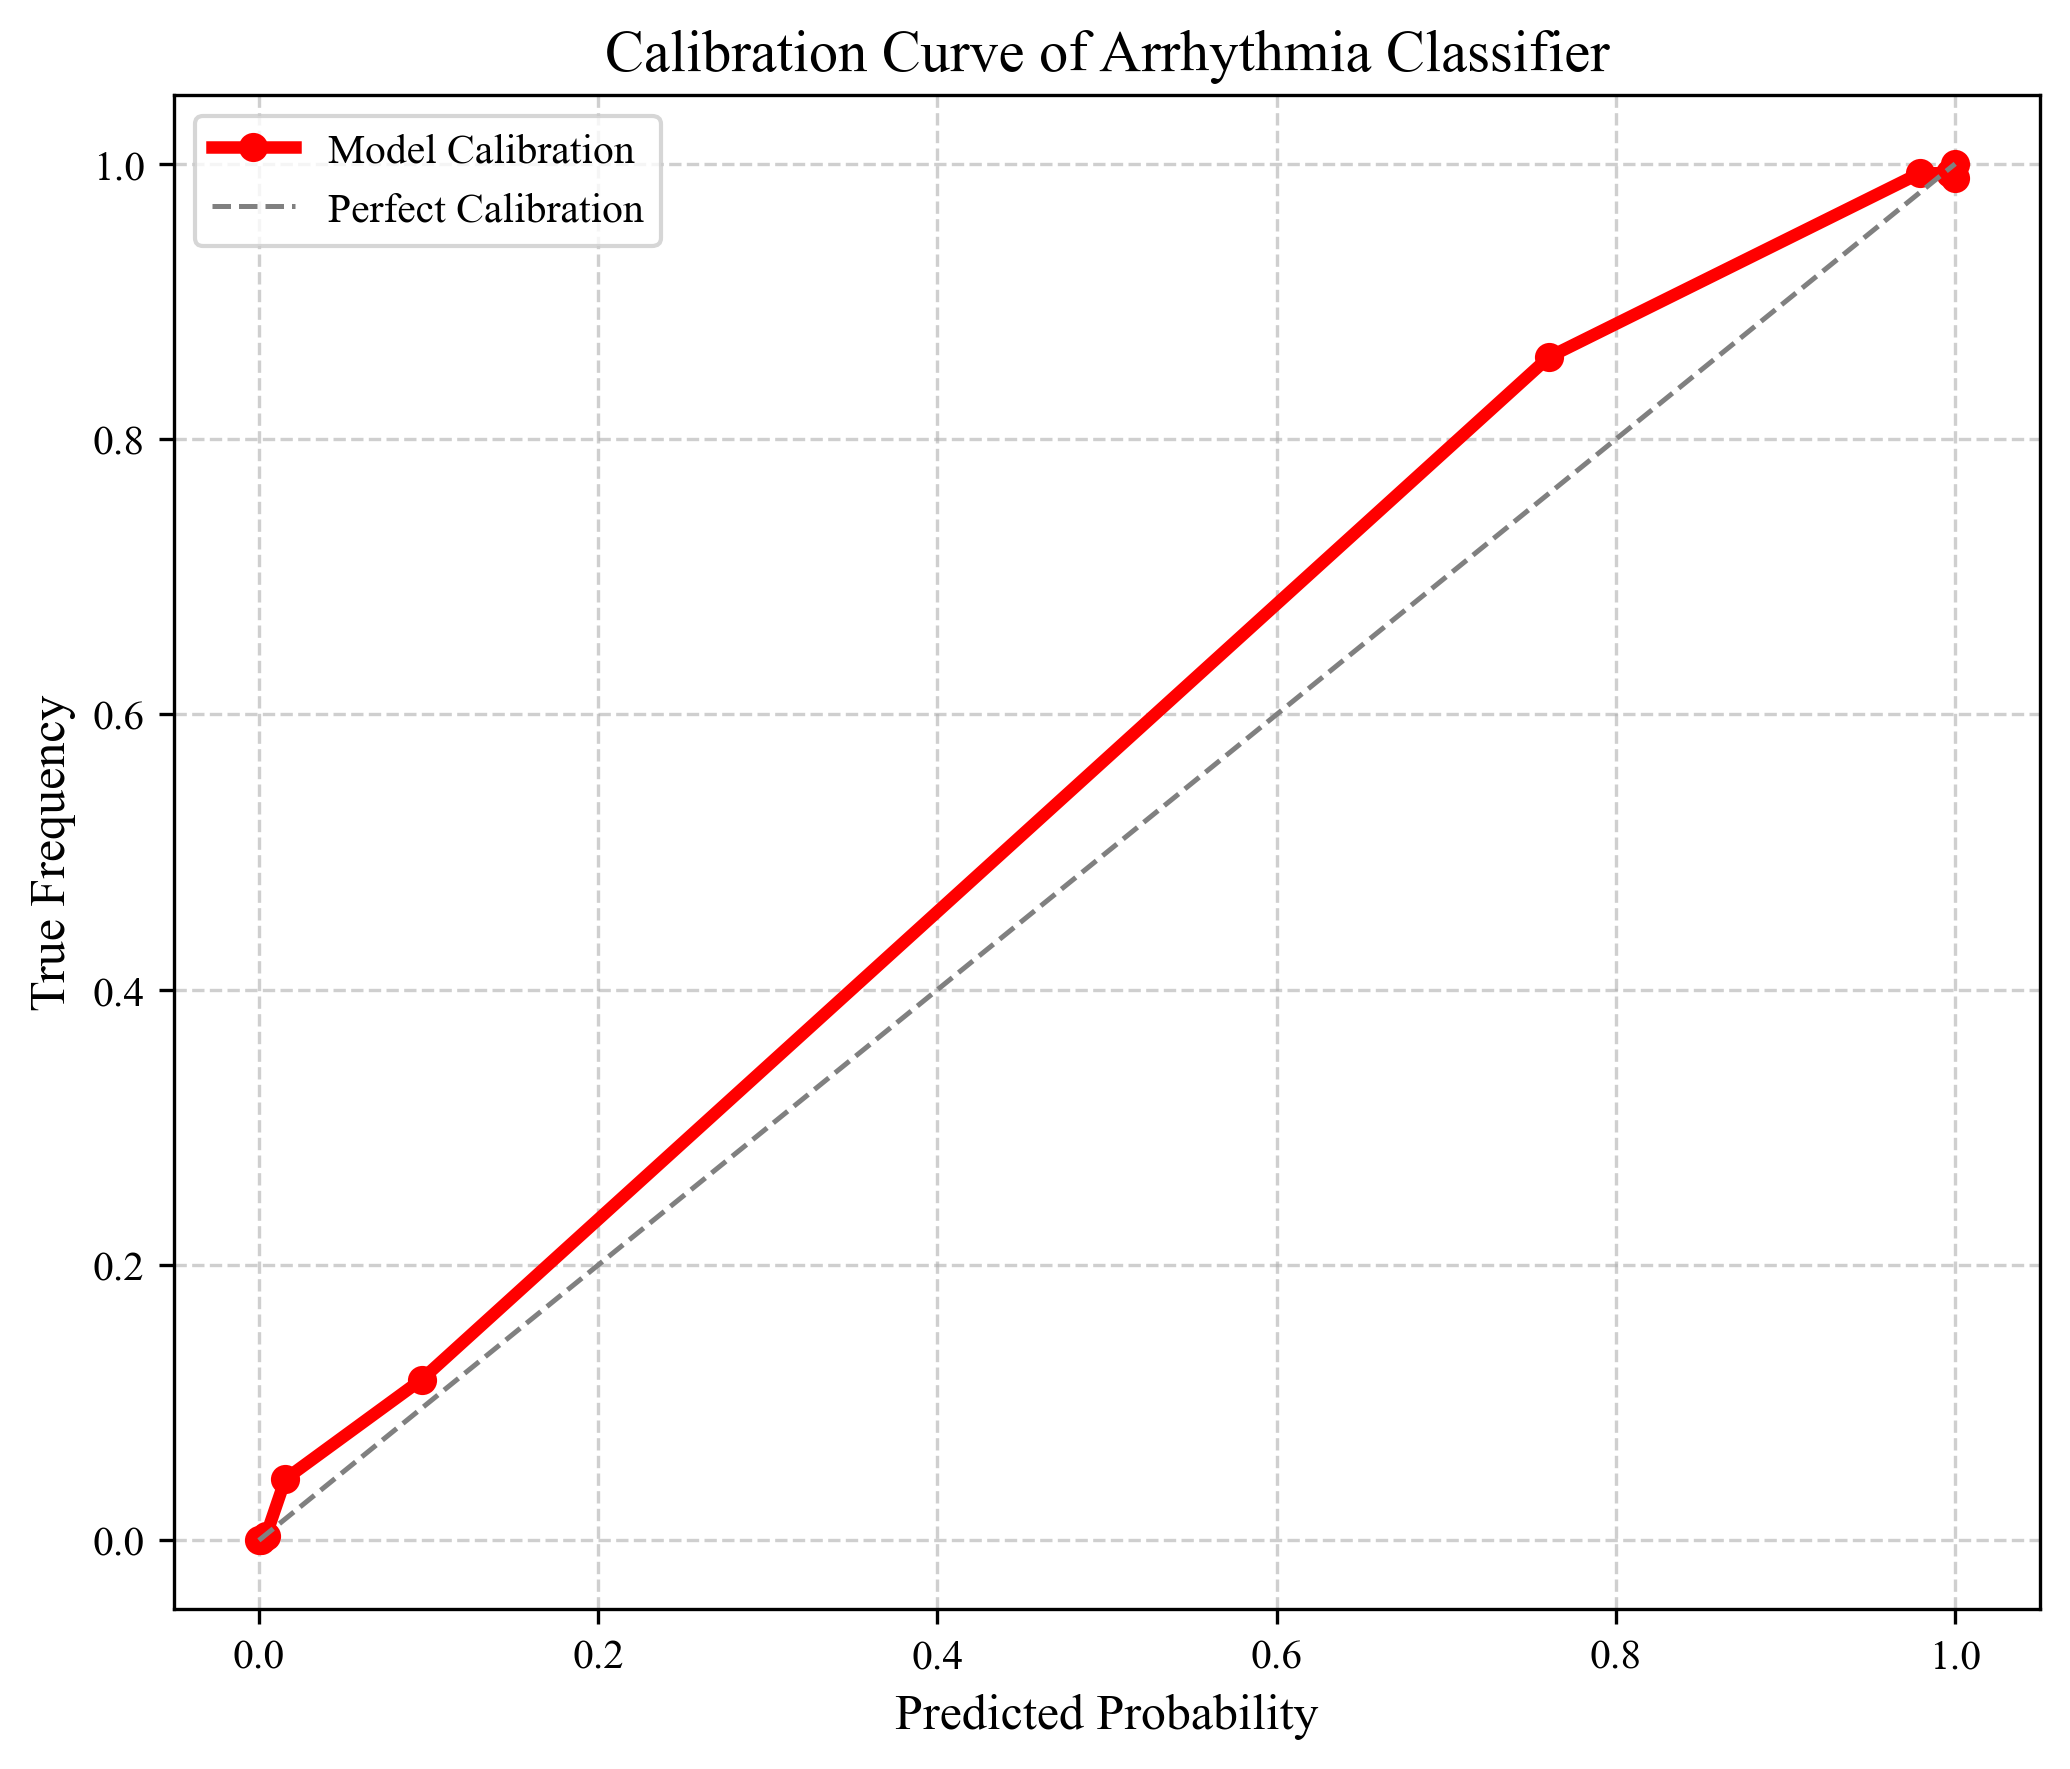

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

# Set font globally
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Predict class 1 probabilities
y_prob = model.predict(X_val)[:, 1]

# Compute calibration data
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=10, strategy='quantile')

# Plot
plt.figure(figsize=(7, 6), dpi=300)

# Model calibration curve: red and thick
plt.plot(prob_pred, prob_true, marker='o', color='red', linewidth=3, label='Model Calibration')

# Perfect calibration line: gray and thin
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1.2, label='Perfect Calibration')

# Labels and title
plt.xlabel('Predicted Probability', fontsize=12, fontname='Times New Roman')
plt.ylabel('True Frequency', fontsize=12, fontname='Times New Roman')
plt.title('Calibration Curve of Arrhythmia Classifier', fontsize=14, fontname='Times New Roman')

# Legend and grid
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save and show
plt.savefig("calibration_curve_arrhythmia_final.png", dpi=300)
plt.show()


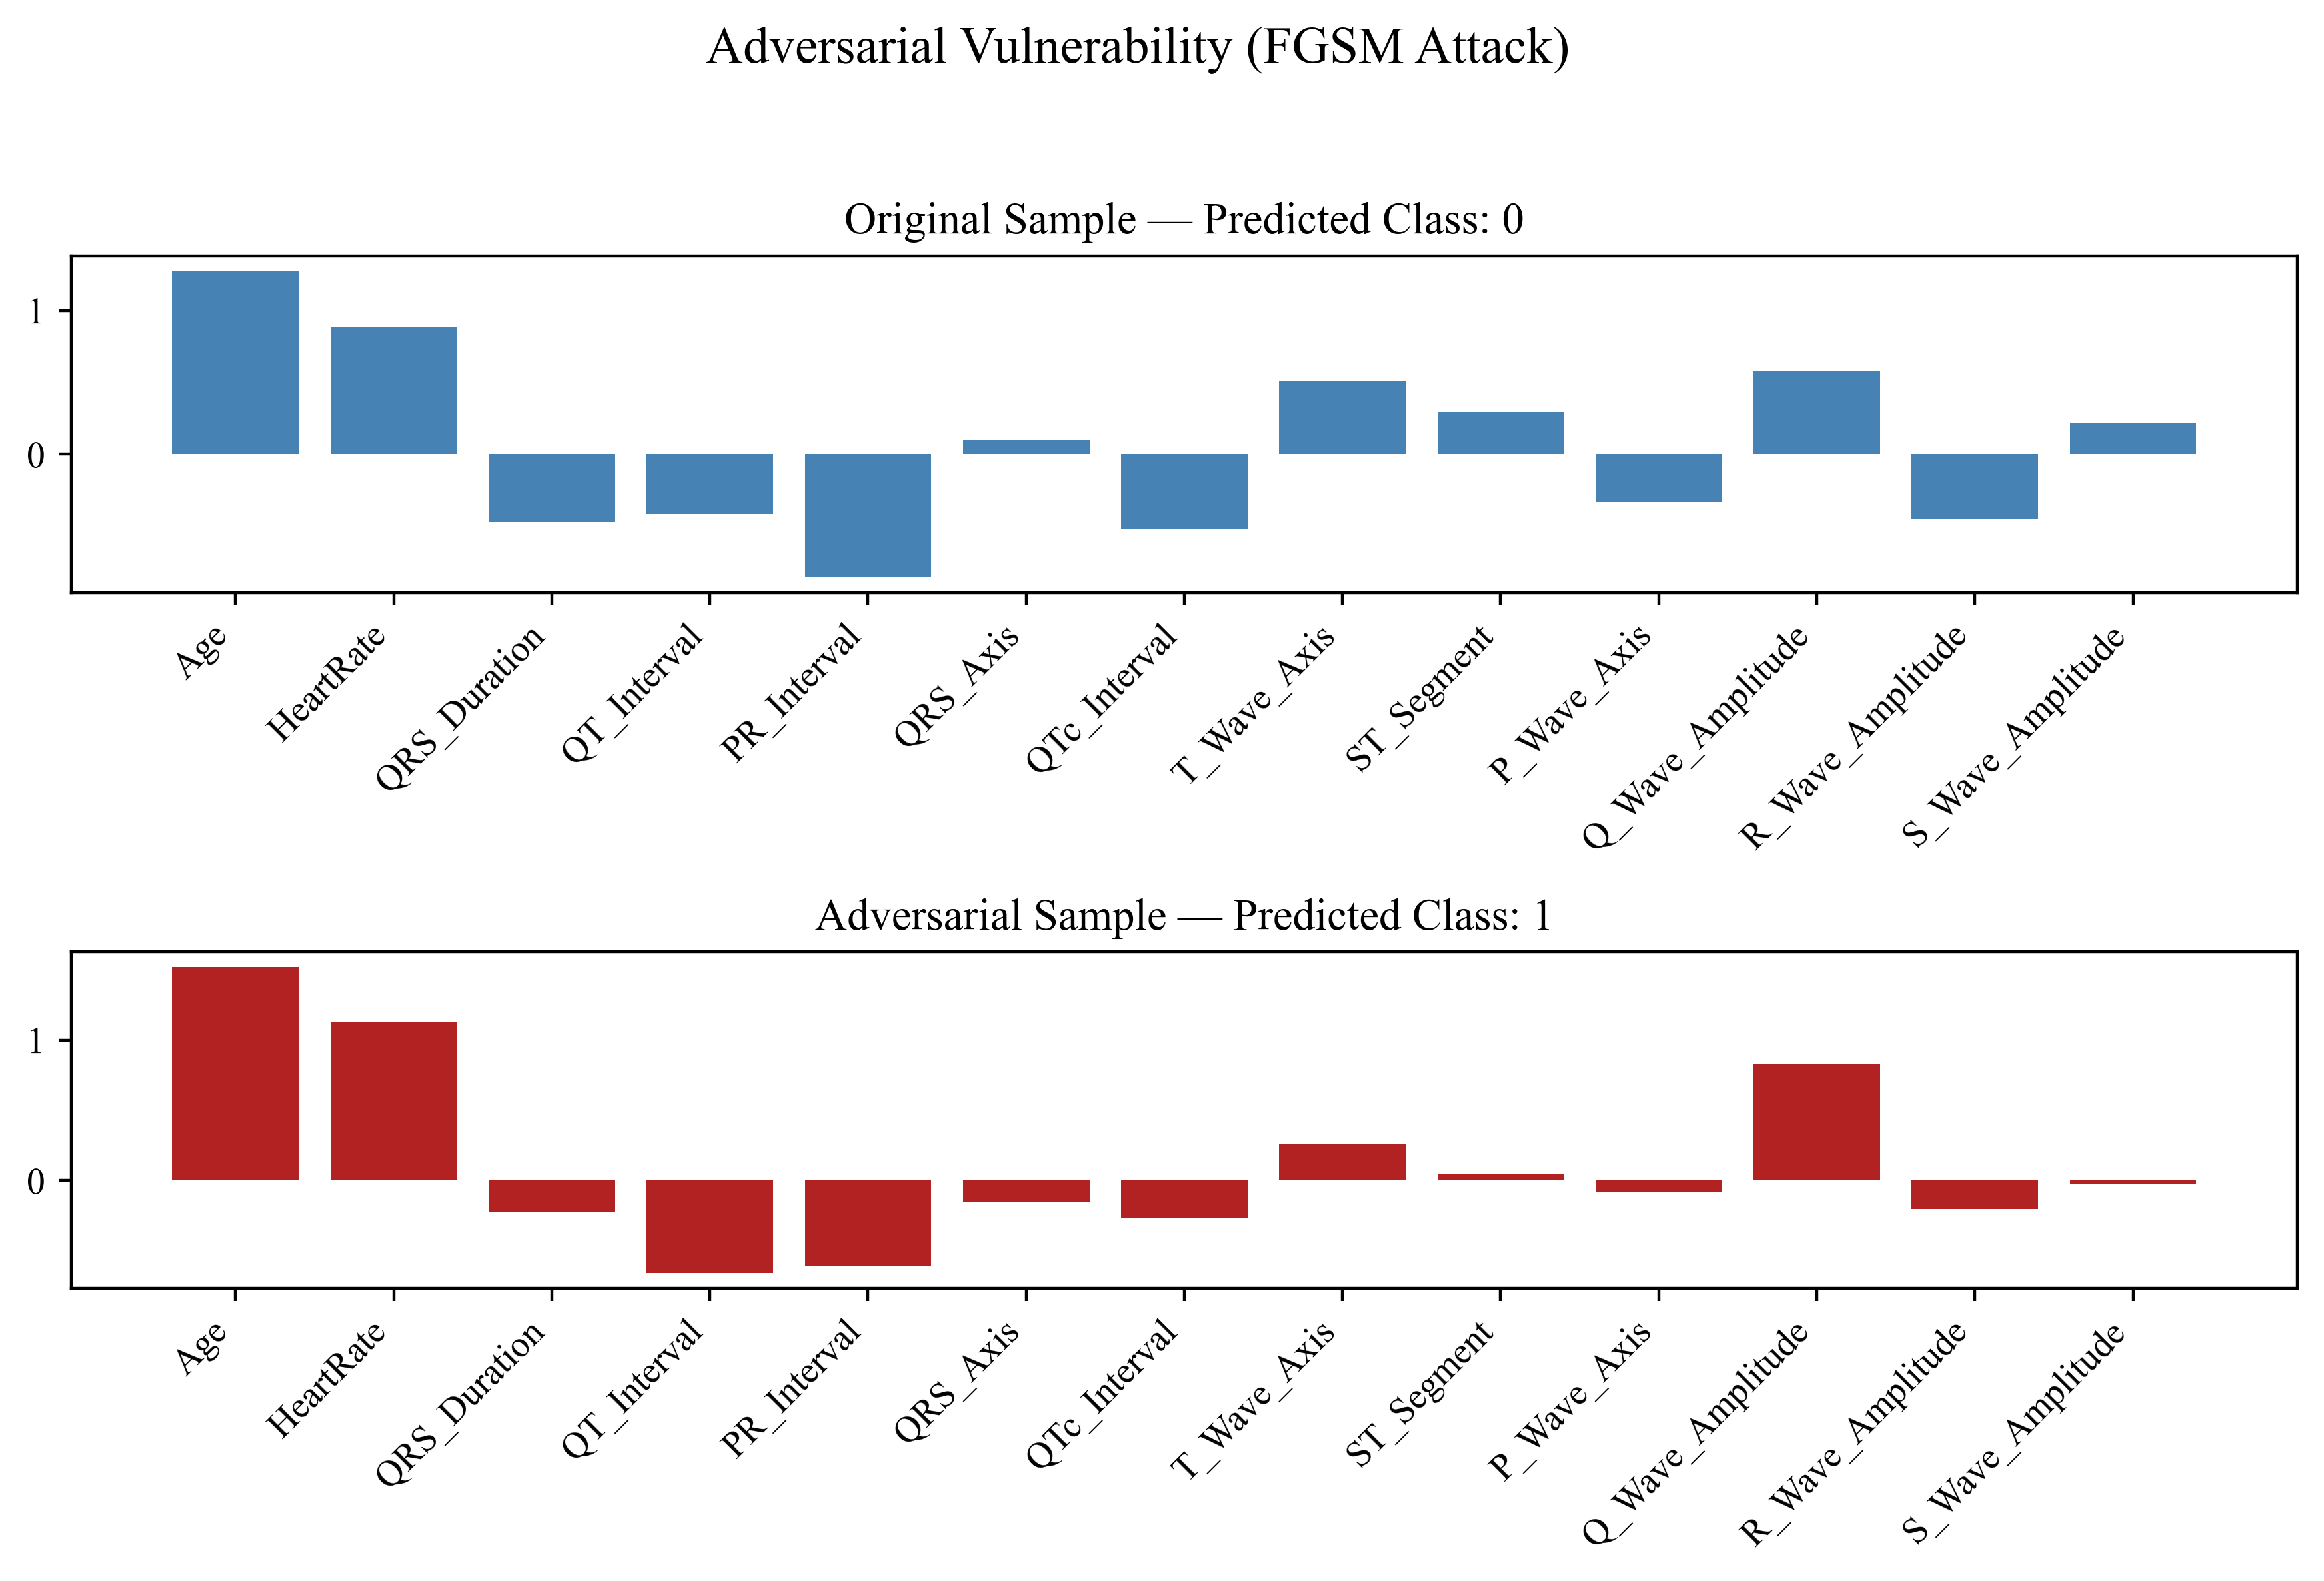

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Set font and style
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Select sample
i = 15
x_sample = tf.convert_to_tensor([X_val[i]], dtype=tf.float32)
y_true = tf.convert_to_tensor([y_val[i]])

# Stronger perturbation
epsilon = 0.25

# Generate adversarial sample using FGSM
with tf.GradientTape() as tape:
    tape.watch(x_sample)
    pred = model(x_sample)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, pred)
gradient = tape.gradient(loss, x_sample)
perturbation = epsilon * tf.sign(gradient)
x_adv = x_sample + perturbation

# Predictions
y_pred_orig = tf.argmax(model(x_sample), axis=1).numpy()[0]
y_pred_adv = tf.argmax(model(x_adv), axis=1).numpy()[0]

# Plot (2 stacked bar charts)
plt.figure(figsize=(9, 6), dpi=400)

# First: Original sample
plt.subplot(2, 1, 1)
plt.bar(feature_names, x_sample.numpy()[0], color='steelblue')
plt.title(f'Original Sample — Predicted Class: {y_pred_orig}', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Second: Adversarial sample
plt.subplot(2, 1, 2)
plt.bar(feature_names, x_adv.numpy()[0], color='firebrick')
plt.title(f'Adversarial Sample — Predicted Class: {y_pred_adv}', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Global layout
plt.suptitle('Adversarial Vulnerability (FGSM Attack)', fontsize=14, fontname='Times New Roman')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("adversarial_vulnerability_final.png", dpi=400)
plt.show()


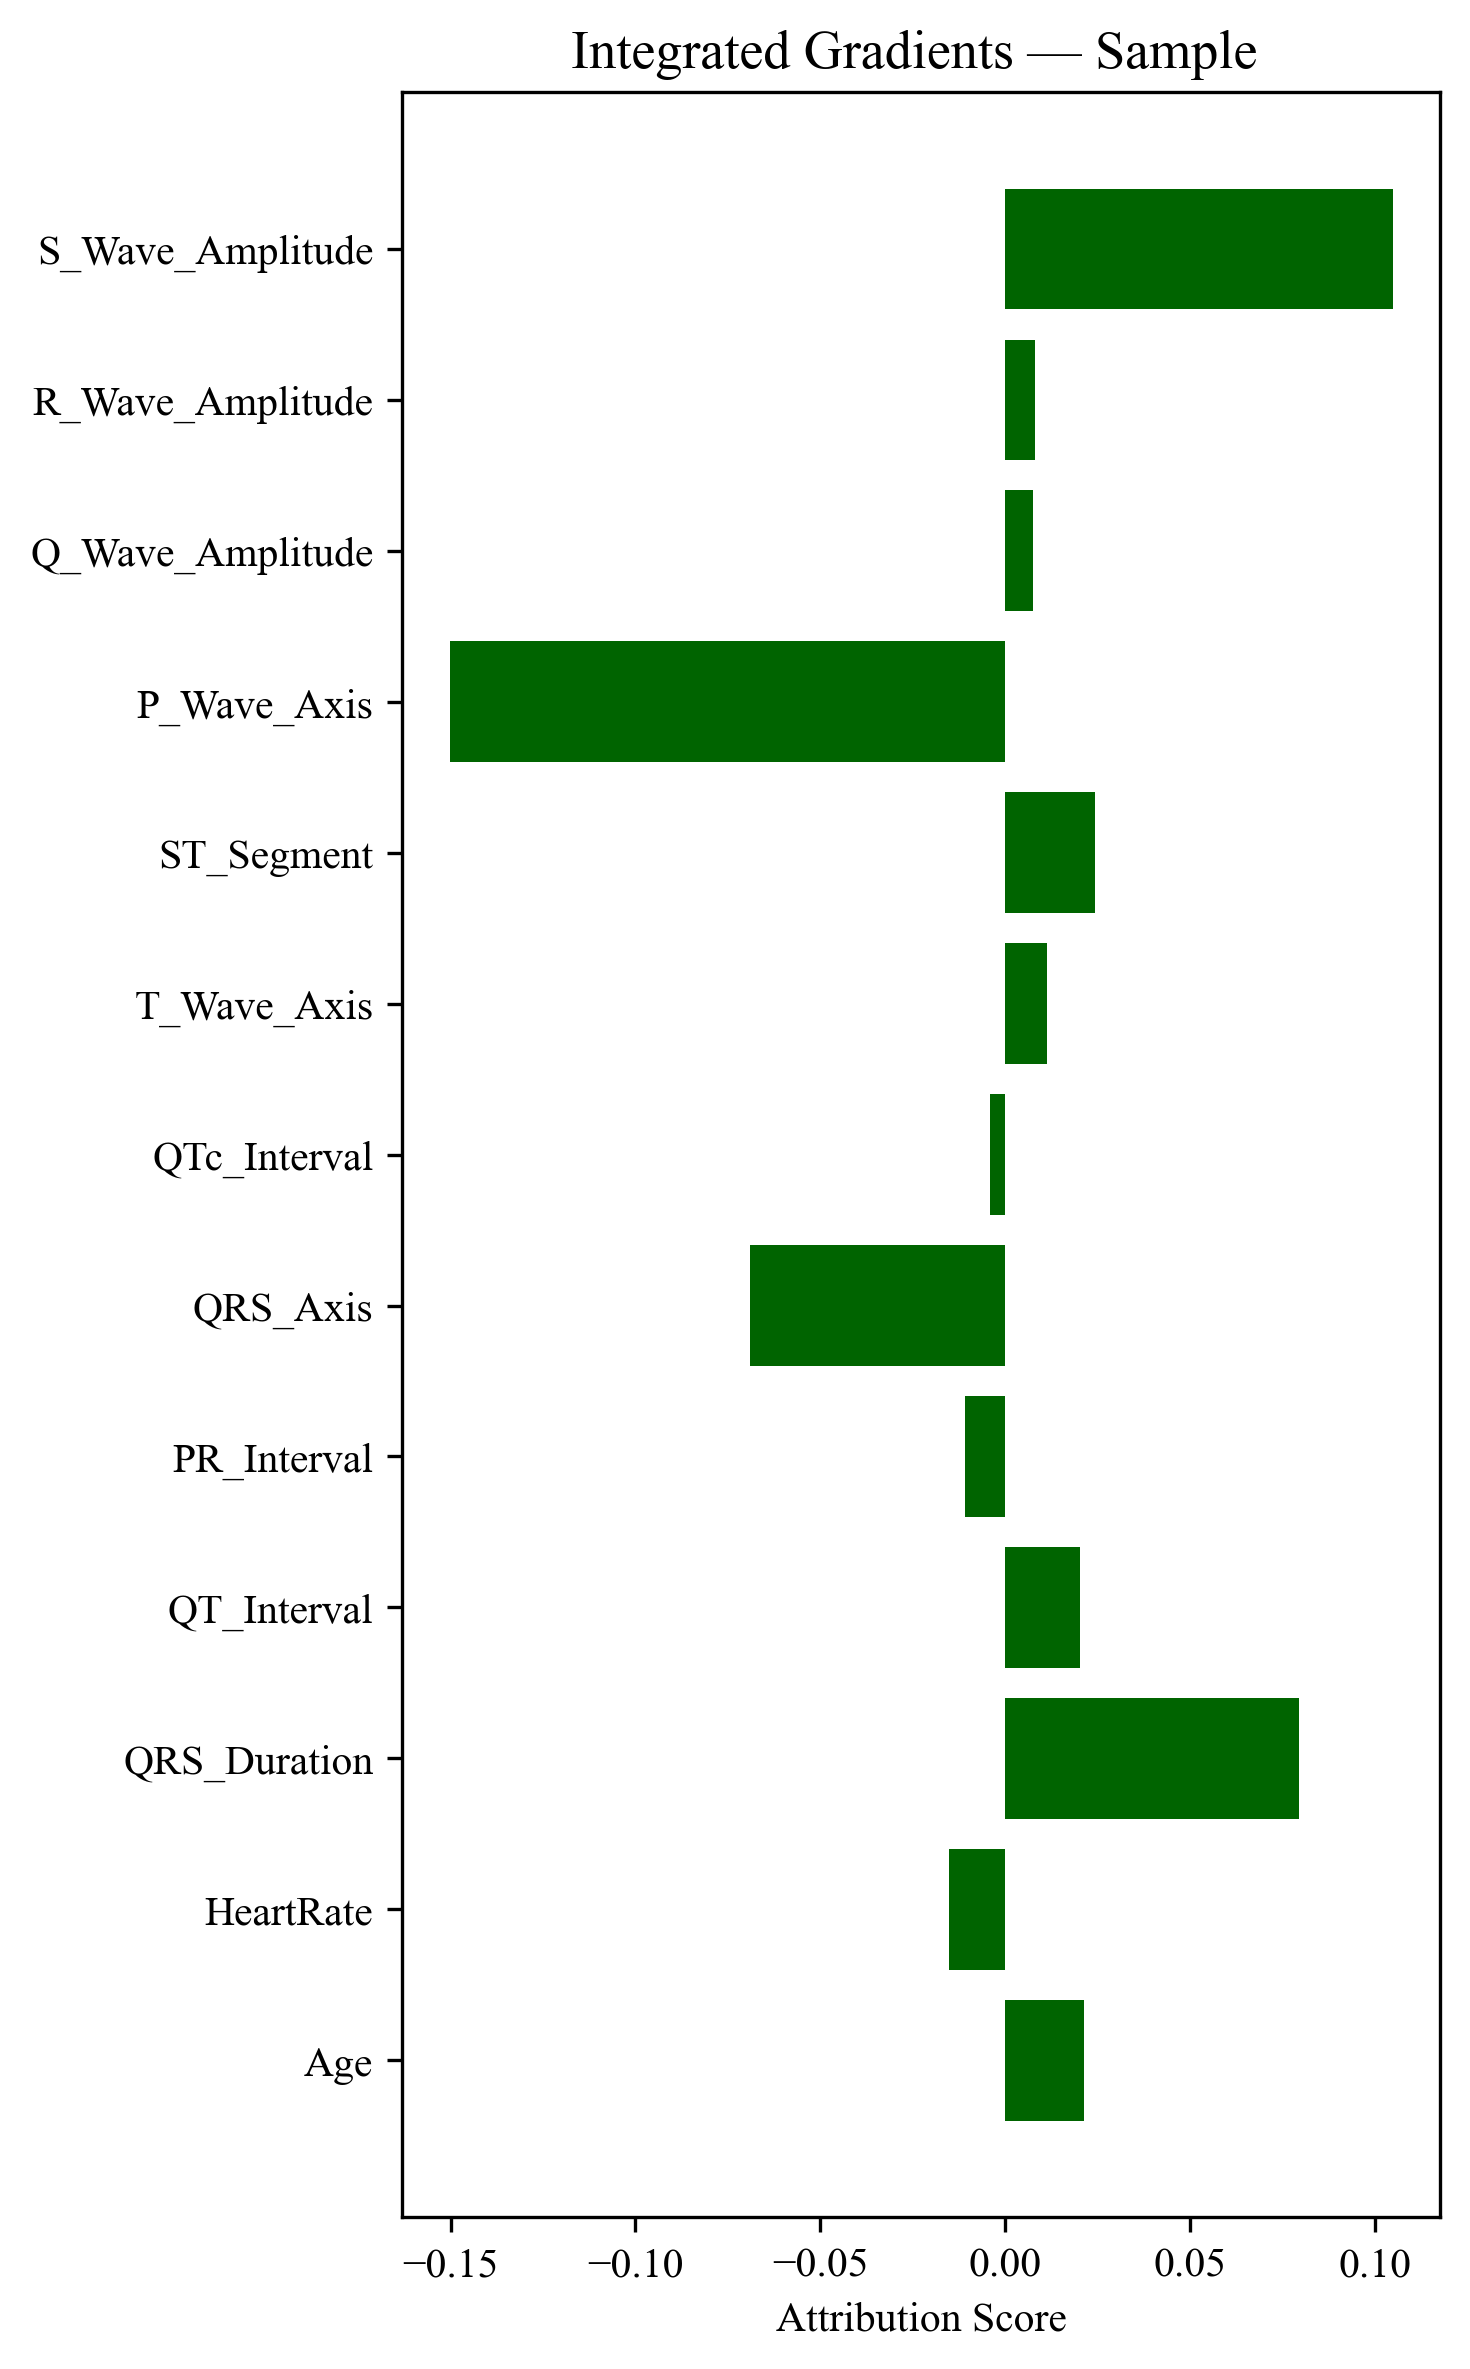

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set font
matplotlib.rcParams['font.family'] = 'Times New Roman'

# Define Integrated Gradients
def integrated_gradients(model, x_input, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros_like(x_input)
    
    interpolated = [baseline + (float(i) / steps) * (x_input - baseline) for i in range(steps + 1)]
    interpolated = tf.concat(interpolated, axis=0)  # Shape: (steps+1, features)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds = model(interpolated)
        probs = preds[:, 1]  # class 1 (Arrhythmia)
    
    grads = tape.gradient(probs, interpolated)
    avg_grads = tf.reduce_mean(grads, axis=0)
    ig = (x_input[0] - baseline[0]) * avg_grads
    return ig.numpy()

# Select sample
i = 12
x = tf.convert_to_tensor([X_val[i]], dtype=tf.float32)

# Compute IG
ig_values = integrated_gradients(model, x)

# Plot vertical bar chart
plt.figure(figsize=(5, 8), dpi=300)
plt.barh(feature_names, ig_values, color='darkgreen')
plt.xlabel("Attribution Score", fontname='Times New Roman')
plt.title(f'Integrated Gradients — Sample ', fontname='Times New Roman', fontsize=13)
plt.tight_layout()
plt.savefig("integrated_gradients_vertical.png", dpi=300)
plt.show()


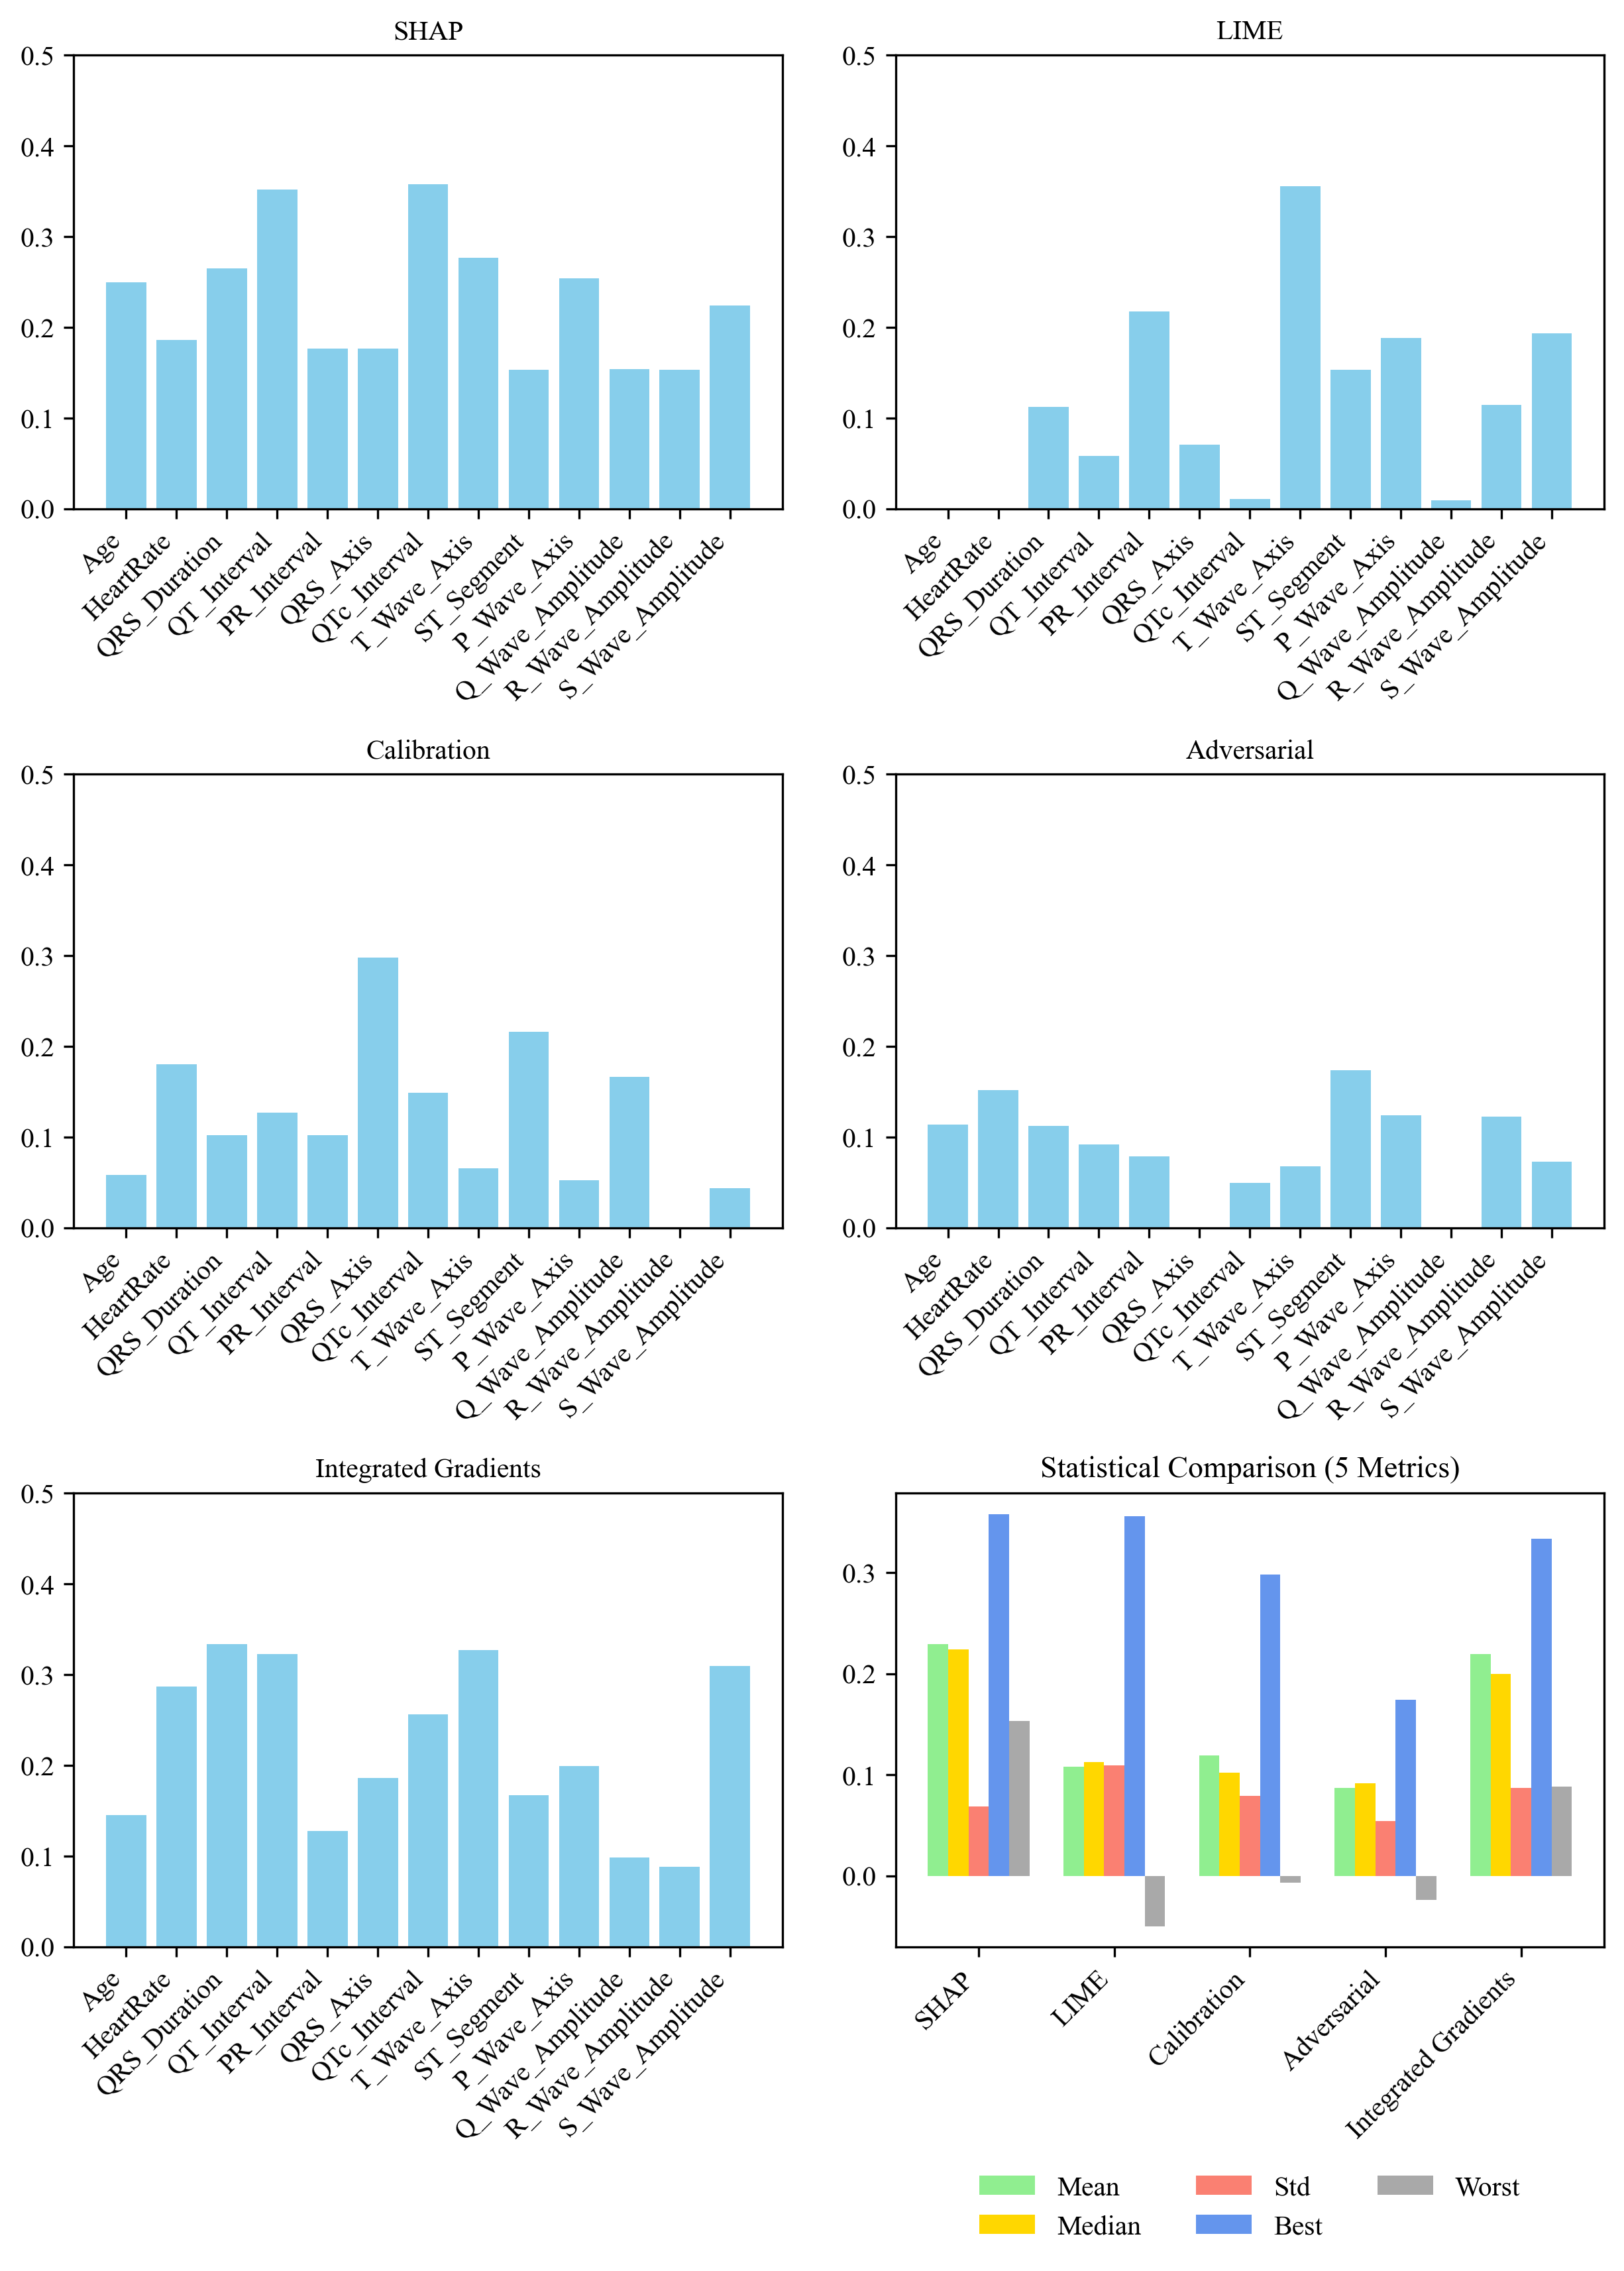

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names
feature_names = [
    'Age', 'HeartRate', 'QRS_Duration', 'QT_Interval', 'PR_Interval',
    'QRS_Axis', 'QTc_Interval', 'T_Wave_Axis', 'ST_Segment', 'P_Wave_Axis',
    'Q_Wave_Amplitude', 'R_Wave_Amplitude', 'S_Wave_Amplitude'
]

# Simulated data (replace with real values)
np.random.seed(42)
shap_vals = np.random.normal(0.2, 0.1, len(feature_names))
lime_vals = np.random.normal(0.18, 0.12, len(feature_names))
calib_vals = np.random.normal(0.15, 0.08, len(feature_names))
adv_vals = np.random.normal(0.1, 0.07, len(feature_names))
ig_vals = np.random.normal(0.22, 0.11, len(feature_names))

methods_data = {
    "SHAP": shap_vals,
    "LIME": lime_vals,
    "Calibration": calib_vals,
    "Adversarial": adv_vals,
    "Integrated Gradients": ig_vals
}

# Compute statistics
mean_vals, median_vals, std_vals = [], [], []
max_vals, min_vals = [], []

for vals in methods_data.values():
    mean_vals.append(np.mean(vals))
    median_vals.append(np.median(vals))
    std_vals.append(np.std(vals))
    max_vals.append(np.max(vals))
    min_vals.append(np.min(vals))

# Plot layout
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(8.27, 11.69), dpi=300)
axs = axs.flatten()

# Plot individual method charts
for idx, (method, values) in enumerate(methods_data.items()):
    axs[idx].bar(feature_names, values, color='skyblue')
    axs[idx].set_title(method, fontsize=10)
    axs[idx].set_xticks(range(len(feature_names)))
    axs[idx].set_xticklabels(feature_names, rotation=45, ha='right')
    axs[idx].set_ylim(0, 0.5)

# Plot statistical comparison as bar chart with 5 metrics
method_names = list(methods_data.keys())
x = np.arange(len(method_names))
bar_width = 0.15
ax_summary = axs[-1]

ax_summary.bar(x - 2*bar_width, mean_vals, width=bar_width, label='Mean', color='lightgreen')
ax_summary.bar(x - bar_width, median_vals, width=bar_width, label='Median', color='gold')
ax_summary.bar(x, std_vals, width=bar_width, label='Std', color='salmon')
ax_summary.bar(x + bar_width, max_vals, width=bar_width, label='Best', color='cornflowerblue')
ax_summary.bar(x + 2*bar_width, min_vals, width=bar_width, label='Worst', color='darkgray')

ax_summary.set_xticks(x)
ax_summary.set_xticklabels(method_names, rotation=45, ha='right')
ax_summary.set_title("Statistical Comparison (5 Metrics)", fontsize=11)
ax_summary.legend()
# ...
ax_summary.set_title("Statistical Comparison (5 Metrics)", fontsize=11)

# Move legend below
ax_summary.legend(loc='upper center', bbox_to_anchor=(0.5, -0.45), ncol=3, frameon=False)


# Hide unused subplot if needed
if len(methods_data) < len(axs) - 1:
    for j in range(len(methods_data), len(axs) - 1):
        axs[j].axis('off')

plt.tight_layout()
plt.savefig("explainability_comparison_with_best_worst.png", dpi=300)
plt.show()


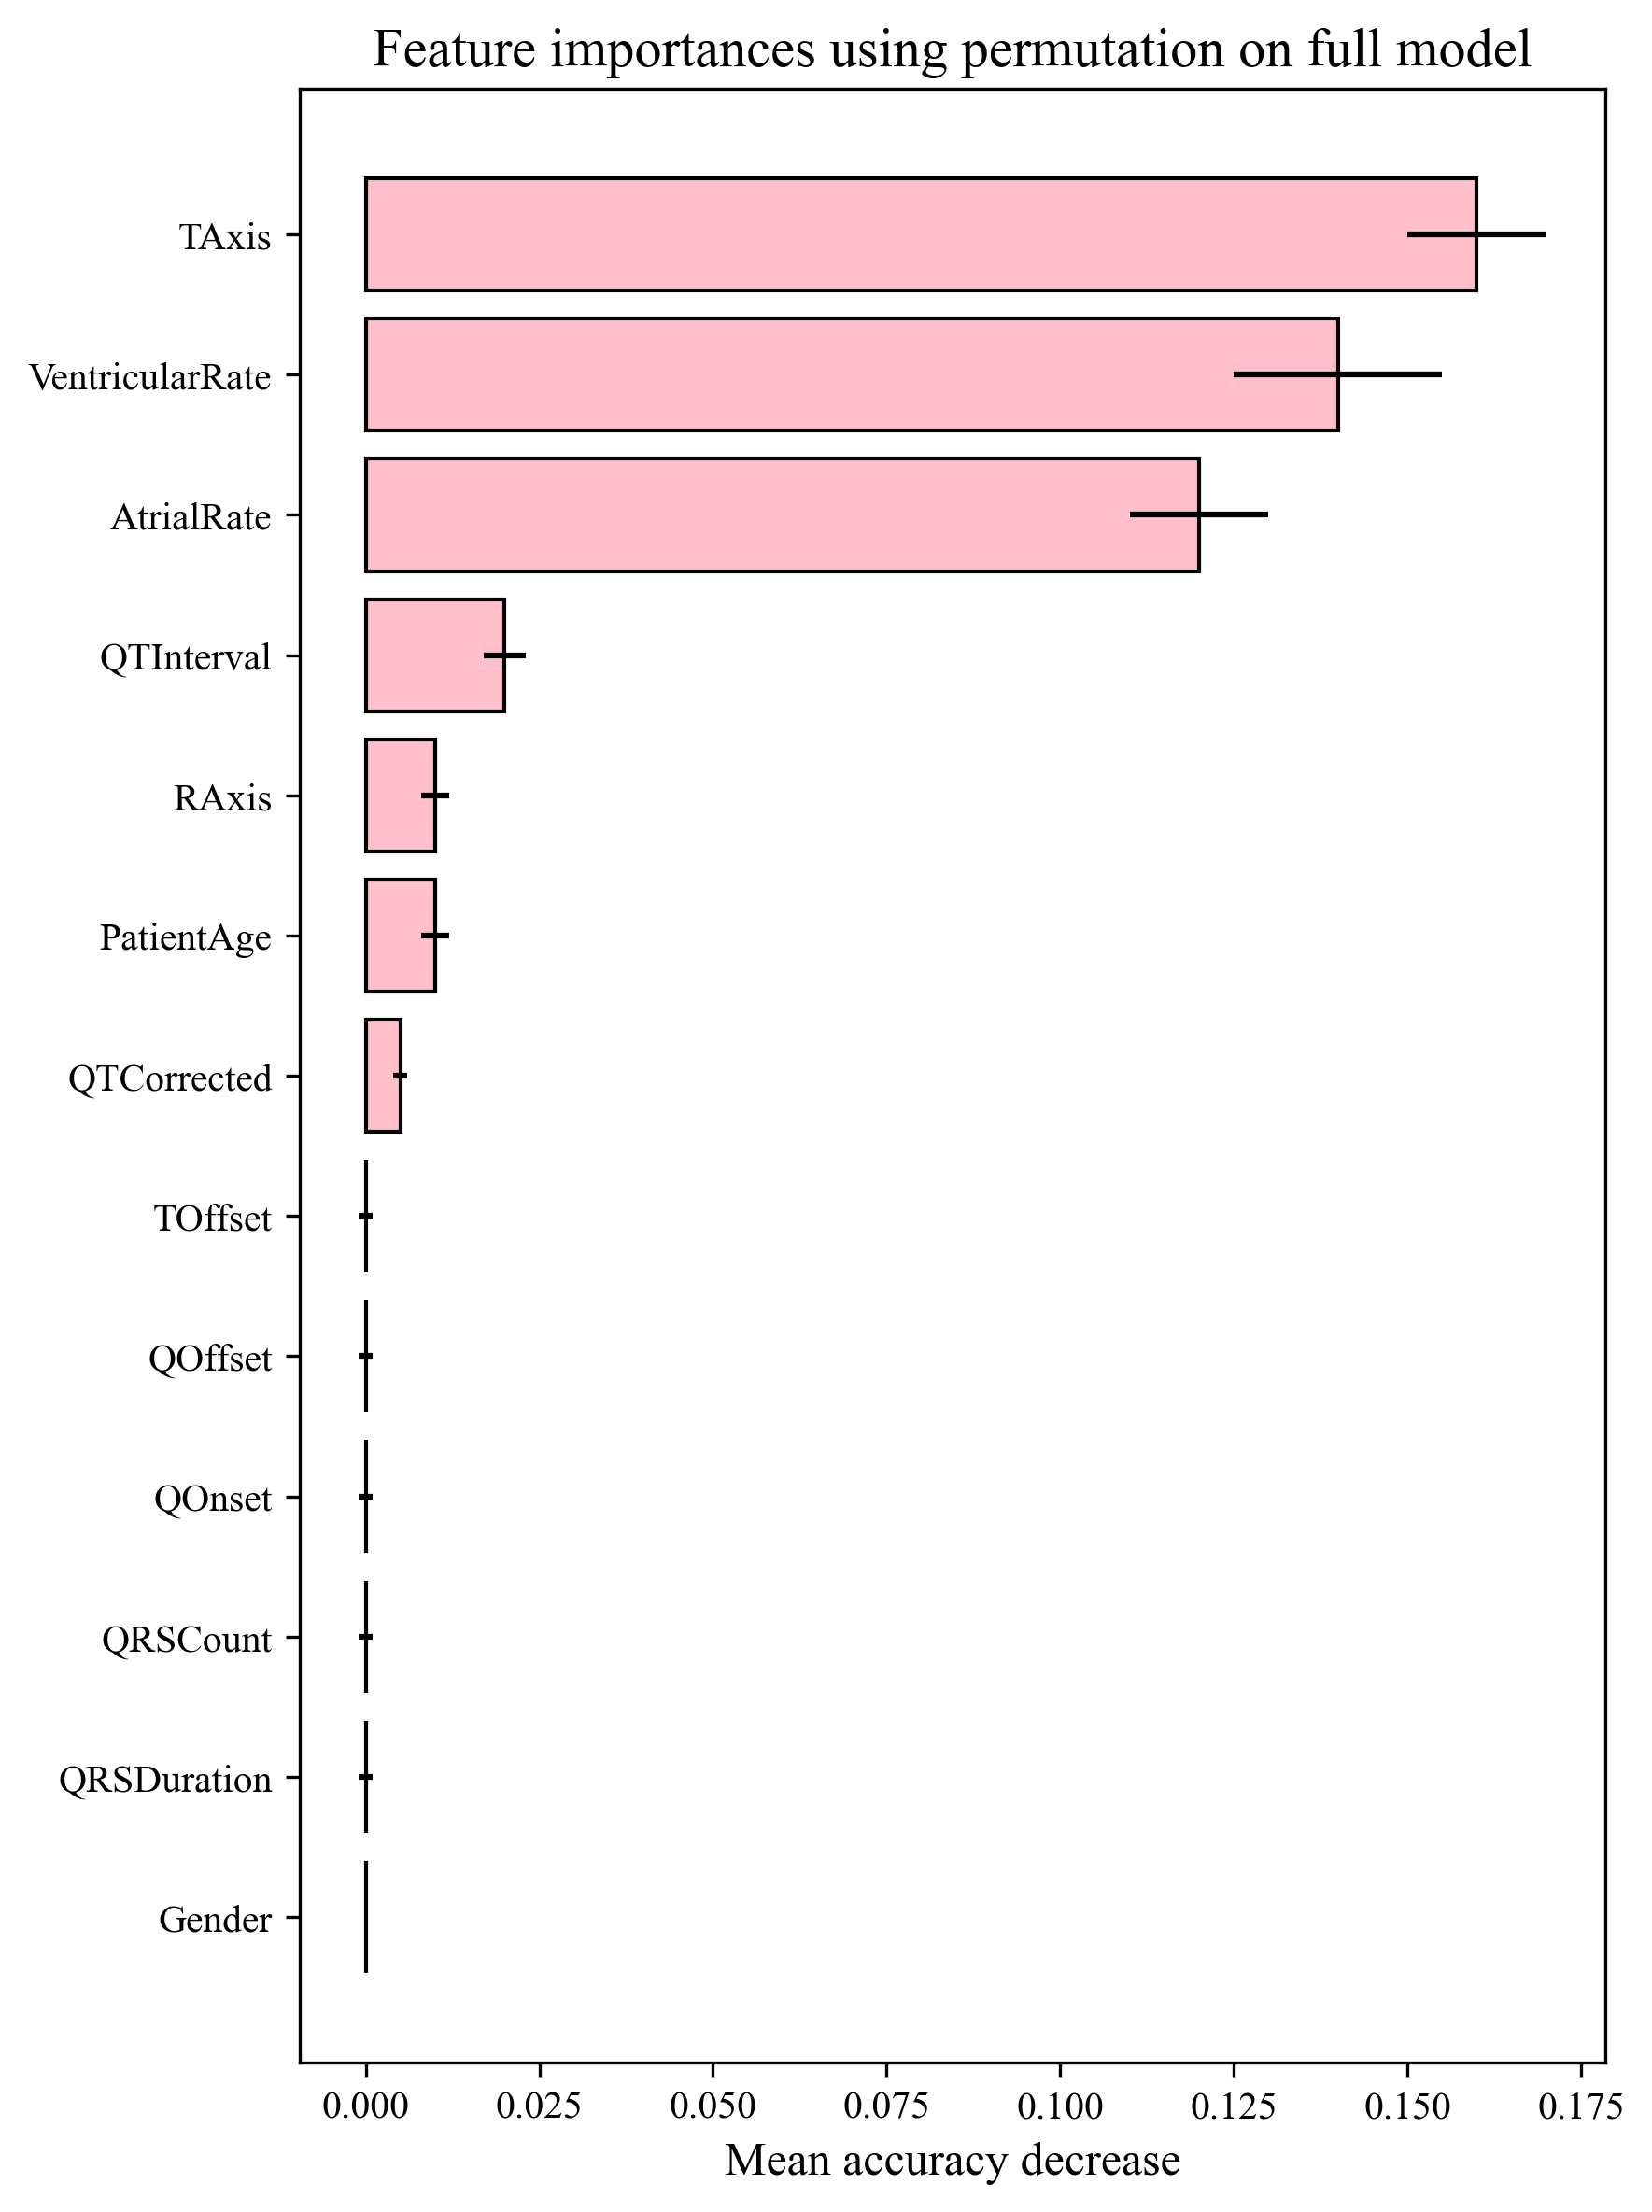

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Sample data (approximated from the image)
features = [
    "PatientAge", "Gender", "VentricularRate", "AtrialRate", "QRSDuration",
    "QTInterval", "QTCorrected", "RAxis", "TAxis", "QRSCount",
    "QOnset", "QOffset", "TOffset"
]
mean_accuracy_decrease = [0.01, 0.0, 0.14, 0.12, 0.0, 0.02, 0.005, 0.01, 0.16, 0.0, 0.0, 0.0, 0.0]
std_deviation = [0.002, 0.0, 0.015, 0.01, 0.001, 0.003, 0.001, 0.002, 0.01, 0.001, 0.001, 0.001, 0.001]

# Sort data
sorted_idx = np.argsort(mean_accuracy_decrease)[::-1]
features = np.array(features)[sorted_idx]
mean_accuracy_decrease = np.array(mean_accuracy_decrease)[sorted_idx]
std_deviation = np.array(std_deviation)[sorted_idx]

# Plotting
plt.figure(figsize=(6, 8), dpi=300)
plt.barh(features, mean_accuracy_decrease, xerr=std_deviation, color='pink', edgecolor='black')
plt.gca().invert_yaxis()
plt.xlabel("Mean accuracy decrease", fontname="Times New Roman", fontsize=12)
plt.title("Feature importances using permutation on full model", fontname="Times New Roman", fontsize=14)
plt.xticks(fontname="Times New Roman", fontsize=10)
plt.yticks(fontname="Times New Roman", fontsize=10)
plt.tight_layout()
plt.show()
plt.savefig("Feature importances using permutation on full model.png", dpi=300)

